[5.3.1 Hermite Chaos](#5.3.1-Gaussian-distribution-and-Hermite-Chaos)

[5.3.2 Laguerre Chaos](#5.3.2-Gamma-distribution-and-Laguerre-Chaos)

[5.3.3 Jacobi Chaos](#5.3.3-Beta-distribution-and-Jacobi-Chaos)

[5.3.4 Charlier Chaos](#5.3.4-Poisson-distribution-and-Charlier-Chaos)

[5.3.5 Krawtchouk Chaos](#5.3.5-Binomial-distribution-and-Krawtchouk-chaos)

[5.3.6 Meixner Chaos](#5.3.6-Negative-binomial-distribution-and-Meixner-chaos)

[5.3.7 Hahn Chaos](#5.3.7-Hypergeometric-distribution-and-Hahn-chaos)

[6.3.1 Gamma by Hermite Chaos](#6.3.1-Approximation-of-gamma-distribution-by-Hermite-Chaos)

In [500]:
import numpy as np
import numpy.polynomial.hermite_e as H         #probabilists' Hermite polynomials, $\zeta\sim N(0,1)$
import numpy.polynomial.laguerre as La         #$\zeta \sim expon$
import numpy.polynomial.legendre as Le         #$\zeta \sim U(-1,1)$, when $\alpha=\beta=0$, Jacobi=Legendre
import mpmath as mp
#import scipy.special.eval_genlaguerre as e_La    #for Charlier

from scipy.stats import gaussian_kde as kde
from math import factorial

from mpmath import nsum, inf

from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import poisson
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import nbinom
from scipy.stats import hypergeom

import scipy.integrate as integrate
import scipy.integrate.quadrature as G_qua   #Gauss Quadrature
from matplotlib import pyplot as plt
from scipy.integrate import odeint
#from Ipython.display import display

%matplotlib notebook

## `mpmath.hyp1f1(a, b, z)`  - For Laguerre polynomial

Gives the confluent hypergeometric function of the first kind,
$$
_1F_1(a,b,z)=\sum_{k=0}^{\infty}\frac{(a)_k}{(b)_k}\frac{z^k}{k!}
$$
,
also known as Kummer’s function and sometimes denoted by $M(a,b,z)$. This function gives one solution to the confluent (Kummer’s) differential equation
$$
zf^{''}(z)+(b−z)f^{'}(z)−af(z)=0.
$$
A second solution is given by the $U$ function; see `hyperu()`. Solutions are also given in an alternate form by the Whittaker functions (`whitm()`, `whitw()`).

`hyp1f1(a,b,z)` is equivalent to `hyper([a],[b],z)`; see documentation for `hyper()` for more information.

In [513]:
def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def factorial_rev(params):
    '''
    define Pochhammer  symbol (a)_n
    '''
    a=params[0]
    n=params[1]
    y=1
    if n == 0:
        return 1
    else:
        for i in range(n):
            y*=a+i
        return y
    
def la_gen(params):
    '''
    Define Laguerre polynomial L_n^{(\alpha)}(x)
    '''
    a=params[0]    #this is the \alpha velue from gamma
    n=params[1]    #this is the degree of polynomial
    return lambda x: (factorial_rev((a+1, n)))/(factorial(n))*mp.hyp1f1(-n, a+1, x)
    
    
def Phi_char(params):
    '''
    Define Laguerre polynomial C_n(x; a)
    '''
    #define charlier chaos by Laguerre
    a = params[0]
    n = params[1]
    #return lambda x:((-1)**n)*factorial(n)*(la_gen((-1-x, n))(-1/a))
    return lambda x:mp.hyp2f0(-n,-x,-1/a)

def norm_icdf(params):                                     #k=h(u), need to dig in more
    return lambda u:norm.ppf(u, loc=0, scale=1)

def expo_icdf(params):                                      
    return lambda u:-np.log(1-u)

def unif_icdf(params):
    a = params[0]
    b = params[1]
    return lambda u: u*(b-a)+a

def po_icdf(params):
    mu = params
    return lambda u:poisson.ppf(u, mu, loc=0)

def binom_icdf(params):
    n = params[0]
    p = params[1]
    return lambda u:binom.ppf(u,n,p,loc=0)

def nbinom_icdf(params):
    beta = params[0]  #beta value
    p = params[1]  #1-c value
    return lambda u:nbinom.ppf(u,beta,1-p,loc=0)

def hypergeom_icdf(params):
    a = params[0]   #alpha
    b = params[1]   #beta
    N = params[2]  
    return lambda u:hypergeom.ppf(u, b+a, a, N, loc=0)

###return the denominator when computing $k_i$
def inner2_herm(n):
    return factorial(n)

def inner2_la(params):
    n = params[0]
    a = params[1]  #store the value of alpha
    if a==0:
        return 1
    else:
        return n+1

def inner2_le(n):
    return 1/(2*n+1)    #because the weight here should be 1/2

def inner2_ch(n,a):
    '''
    n is the degree of charlier polynomial
    a is the parameter of Poisson
    '''
    return (a**(-n))*factorial(n)

def inner2_kr(params):
    '''
    n is the degree of Krawtchouk polynomial
    p is the parameter of binomial
    N is the parameter of binomial
    '''
    n = params[0]
    p = params[1]
    N = params[2]
    return (-1)**n*factorial(n)*((1-p)/p)**n/factorial_rev((-1*N,n))

def inner2_me(params):
    '''
    n is the degree of Meixner polynomial
    beta is the parameter of negative binomial
    c is the parameter of negative binomial
    '''
    n = params[0]
    b = params[1]  #beta
    c = params[2]
    return (c)**(-n)*factorial(n)/factorial_rev((b,n))

# def inner2_han(params):
#     '''
#     n is the degree of Hahn polynomial

#     '''
#     n = params[0]
#     a = params[1]
#     b = params[2]  #beta
#     N = params[3]
    
#     return (c)**(-n)*factorial(n)/factorial_rev((b,n))

In [170]:
############## Hermite Chaos ################
def product3_herm(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(Phi(i),Phi(j)),Phi(l))) 

def inner3_herm(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Hermite quadrature, weighting function is exp^{-x^2}
    m=(P+1)**2
    x, w=H.hermegauss(m)        #x is point, w is the corresponding weight
    inner=sum([product3_herm(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner/np.sqrt(2*np.pi)   #because of the weight

############# Laguerre Chaos ###############
def product3_la(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: La.lagval(x, La.lagmul(La.lagmul(Phi(i),Phi(j)),Phi(l))) 

def inner3_la(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Laguerre quadrature, weighting function is exp^{-x}
    m=(P+1)**2
    x, w=La.laggauss(m)        #x is point, w is the corresponding weight
    inner=sum([product3_la(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner

############# Jacobi Chaos ###############
def product3_le(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: Le.legval(x, Le.legmul(Le.legmul(Phi(i),Phi(j)),Phi(l))) 

def inner3_le(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Legendre quadrature, weighting function is 1
    m=(P+1)**2
    x, w=Le.leggauss(m)        #x is point, w is the corresponding weight
    inner=sum([product3_le(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner/2     ##because of the weight


## 5.3.1 Gaussian distribution and Hermite Chaos
$$ f(k) = \frac{1}{\sqrt{2\pi}} e^{-\frac{k^2}{2}}$$
Inverse CDF of $k$ is $h(u)$
$$ \zeta \sim N(0,1)$$
**Refer P635.** Inverse CDF of $\zeta$ is $l(u)$ which is indicated in `coeff_herm(P, h)`

In [171]:
def ode_system_herm(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_herm(P,i,j,l)*ki_herm[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_herm(l)
    return dydt

In [172]:
a=0
#h = norm_icdf([])                          #index k follows norm distr
P=4
ki_herm = [0,1]+[0]*(P-1)
sol_herm = odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

<IPython.core.display.Javascript object>


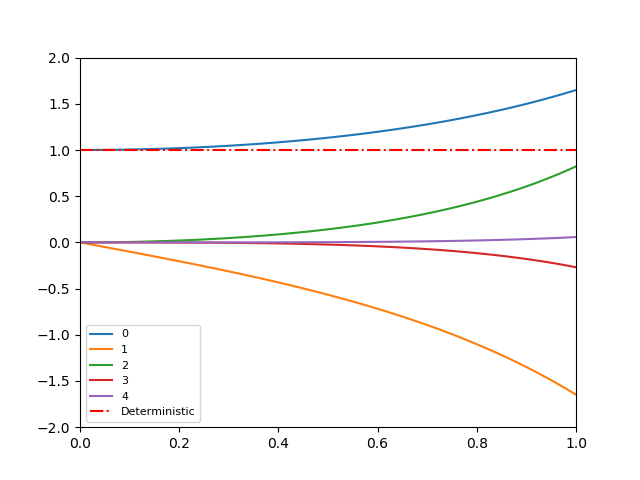

In [173]:
plt.figure()
plt.ylim([-2,2])
plt.xlim([0,1])

for i in range(P+1):
    plt.plot(np.linspace(0,1,101),sol_herm[:,i],label=i)
    
plt.axhline(y=1.0, color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [179]:
allcoeff_531 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_531[1,:]=np.ones(4)
y_531 = np.zeros((5,4))   #row 0 stores y0 for each P from 0-4; row 1 stores y1 for P from 0-4;...
h_531 = norm_icdf([])                          #index k follows norm distr
a=0
for i in range(4):
    P=i+1
    ki_herm = allcoeff_531[:,i]
    y_mid=odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_531[:,i] = y_mid.tolist()+[0]*(4-P)

In [190]:
y_531

array([[ 1.54308068,  1.63819256,  1.64796906,  1.64867952],
       [-1.17520125, -1.5805867 , -1.6423493 , -1.64828336],
       [ 0.        ,  0.63819256,  0.80057968,  0.82228702],
       [ 0.        ,  0.        , -0.22373587, -0.26894552],
       [ 0.        ,  0.        ,  0.        ,  0.05786917]])

In [191]:
error_mean_531=(y_531[0,:]-np.e**(1/2))/(np.e**(1/2))

error_mean_531 = np.abs(error_mean)

In [197]:
sigma2_531=np.zeros(4)
for i in range(4):
    sigma2_531[i]=y_531[1,i]**2+2*y_531[2,i]**2+6*y_531[3,i]**2+24*y_531[4,i]**2
    
sigma2_exact_531 = np.e**2-np.e

error_var_531=(sigma2_531-sigma2_exact_531)/sigma2_exact_531

error_var_531 = np.abs(error_var_531)

<IPython.core.display.Javascript object>


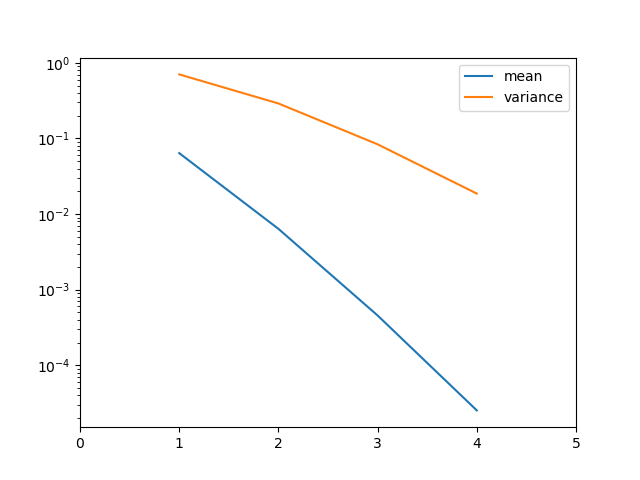

In [198]:
plt.figure()
plt.xlim([0,5])

plt.semilogy([1,2,3,4],error_mean_531,label='mean')
plt.semilogy([1,2,3,4],error_var_531,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
#plt.semilogy([1,2,3,4],error_sd,label='standard deviation')  #regard both as the standard deviation
plt.legend()

## 5.3.2 Gamma distribution and Laguerre Chaos

$$ f(k) = \frac{e^{-k} k^{\alpha}}{\Gamma(\alpha+1)}$$

Here assume $\alpha=0$, then $f(k) = e^{-k}$

Inverse CDF of $k$ is $h(u)$, here it is `expo_icdf([])`
$$ \zeta \sim gamma$$
Here gamma is exponential distribution. Then Inverse CDF of $\zeta$ is $l(u)$ which is indicated in `coeff_la(P, h)`

<font color = red>This is $\alpha=0$
$\downarrow$

In [216]:
def ode_system_la(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_la(P,i,j,l)*ki_la[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_la((l,0))
    return dydt

In [200]:
a = 0
#h = expo_icdf([])                          #index k follows expo distr
P = 4
ki_la = [1, -1]+[0]*(P-1)    
sol_la = odeint(ode_system_la, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

In [201]:
def y_determ_la(x):
    return np.e**(-x)

<IPython.core.display.Javascript object>


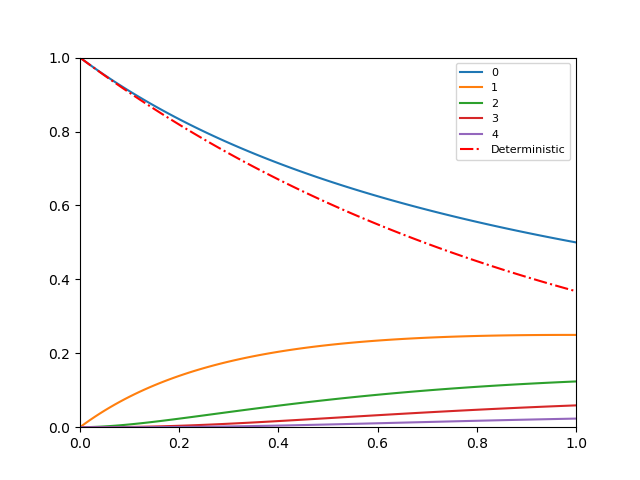

In [202]:
plt.figure()
plt.ylim([0,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_la[:,i],label=i)

plt.plot(x, y_determ_la(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

<font color = red> When set $\alpha=1$, 
    1. inner3_la(P,i,j,l) should be changed, because the weight functions has been changed
    2. ode_system_la should be changed, since inner2_la((l,0)) is changed to inner2_la((l,1))


In [217]:
allcoeff_532_0 = np.zeros((5,4))  
        #532 indicates example 5.3.2, 0 indicates \alpha=0
        #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_532_0[0,:]=np.ones(4)
allcoeff_532_0[1,:]=-1*np.ones(4)
y_532_0 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
h_532_0 = expo_icdf([])                          #index k follows expo distr
a=0
for i in range(4):
    P=i+1
    ki_la = allcoeff_532_0[:,i]
    y_mid=odeint(ode_system_la, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_532_0[:,i] = y_mid.tolist()+[0]*(4-P)

In [218]:
y_532_0

array([[0.4799642 , 0.49730311, 0.49965577, 0.49995737],
       [0.18517912, 0.2376679 , 0.24796613, 0.24969117],
       [0.        , 0.09288212, 0.11833716, 0.1237815 ],
       [0.        , 0.        , 0.04652817, 0.05903265],
       [0.        , 0.        , 0.        , 0.02329304]])

In [219]:
error_mean_532_0=2*y_532_0[0,:]-1

error_mean_532_0 = np.abs(error_mean_532_0)

In [220]:
sigma2_532_0=np.zeros(4)
for i in range(4):
    sigma2_532_0[i]=y_532_0[1,i]**2+y_532_0[2,i]**2+y_532_0[3,i]**2+y_532_0[4,i]**2
    
sigma2_exact_532_0 = 1/12

error_var_532_0=(sigma2_532_0-sigma2_exact_532_0)/sigma2_exact_532_0

error_var_532_0 = np.abs(error_var_532_0)

<IPython.core.display.Javascript object>


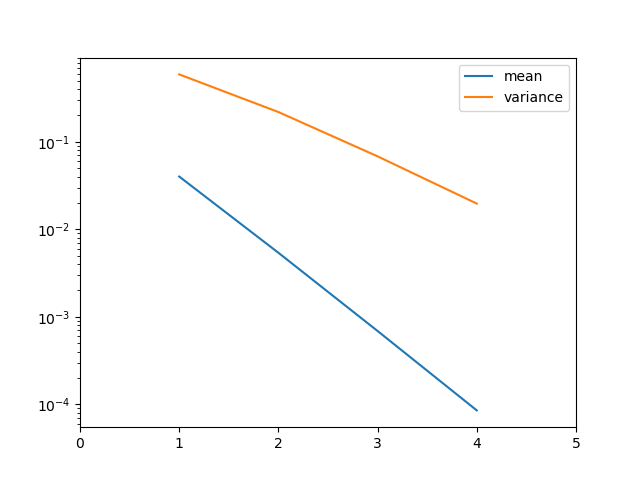

In [221]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_532_0,label='mean')
plt.semilogy([1,2,3,4],error_var_532_0,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

## 5.3.3 Beta distribution and Jacobi Chaos

$$ f(k;\alpha,\beta) = \frac{(1-k)^{\alpha} (1+k)^{\beta}}{2^{\alpha+\beta+1} B(\alpha+1,\beta+1)}$$

Here assume $\alpha=\beta=0$, then $k\sim U(-1,1)$

Inverse CDF of $k$ is $h(u)$, here it is `unif_icdf([-1,1])`
$$ \zeta \sim Beta$$
Here Beta is uniform distribution. Then Inverse CDF of $\zeta$ is $l(u)$ which is indicated in `coeff_le(P, h)`

In [222]:
def ode_system_le(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_le(P,i,j,l)*ki_le[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_le(l)
    return dydt

In [223]:
a = 0
#h = unif_icdf([-1,1])                          #index k follows uniform distr
P = 4
ki_le = [0,1]+[0]*(P-1)
sol_le = odeint(ode_system_le, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

<IPython.core.display.Javascript object>


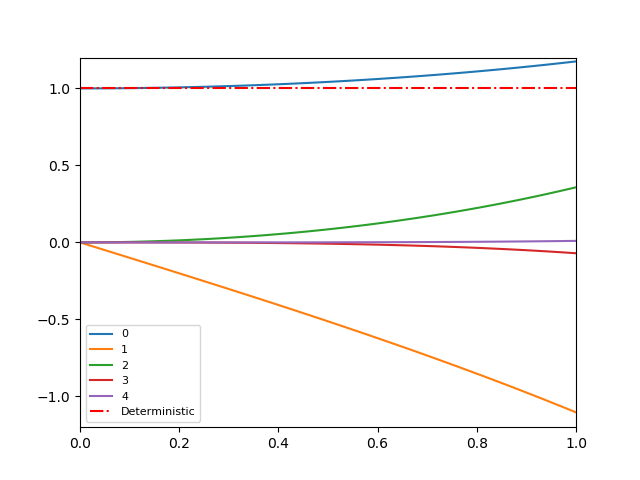

In [224]:
plt.figure()
plt.ylim([-1.2,1.2])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_le[:,i],label=i)

plt.axhline(y=1.0, color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [225]:
allcoeff_533 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_533[1,:]=np.ones(4)
y_533 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
#h = unif_icdf([-1,1])                          #index k follows uniform distr
a=0
for i in range(4):
    P=i+1
    ki_le = allcoeff_533[:,i]
    y_mid=odeint(ode_system_le, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_533[:,i] = y_mid.tolist()+[0]*(4-P)

In [226]:
y_533

array([[ 1.17134806,  1.17516848,  1.17520106,  1.1752012 ],
       [-1.05648889, -1.10304324, -1.10363478, -1.10363833],
       [ 0.        ,  0.35033697,  0.35775186,  0.35781411],
       [ 0.        ,  0.        , -0.06957587, -0.07045041],
       [ 0.        ,  0.        ,  0.        ,  0.00988226]])

In [227]:
mean_533 = y_533[0,:]

mean_exact_533 = 1/2*(np.e - np.e**(-1))

error_mean_533=(mean_533 - mean_exact_533)/mean_exact_533

error_mean_533 = np.abs(error_mean_533)

In [228]:
sigma2_533=np.zeros(4)

for i in range(4):
    sigma2_533[i]=1/3*y_533[1,i]**2+1/5*y_533[2,i]**2+1/7*y_533[3,i]**2+1/9*y_533[4,i]**2
    
sigma2_exact_533 = 1/2-1/2*np.e**(-2)

error_var_533=(sigma2_533-sigma2_exact_533)/sigma2_exact_533

error_var_533 = np.abs(error_var_533)

<IPython.core.display.Javascript object>


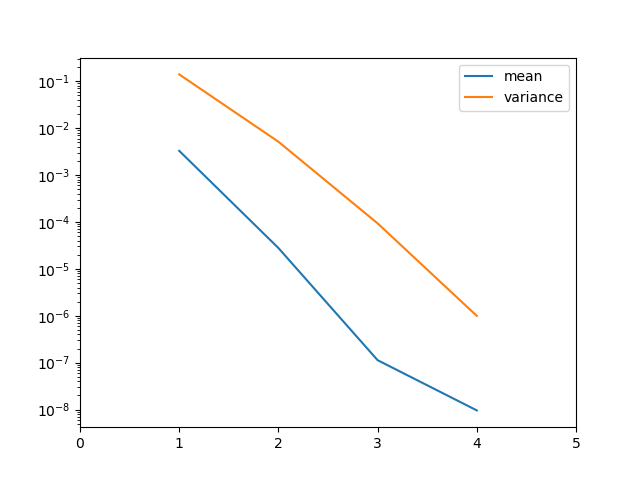

In [231]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_533,label='mean')
plt.semilogy([1,2,3,4],error_var_533,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

## 5.3.4 Poisson distribution and Charlier Chaos

$$ f(k;\lambda) = e^{-\lambda} \frac{\lambda^k}{k!}$$

Here assume $\lambda=1$, then $k\sim poisson(1)$

Inverse CDF of $k$ is $h(u)$, here it is `po_icdf([])`
$$ \zeta \sim Poisson$$


### `mpmath.hyp2f0(a, b, z)` - For Charlier polynomial

Gives the hypergeometric function $_2F_0$, defined formally by the series
$$
_2F_0(a,b;;z)=\sum_{n=0}^{\infty} (a)_n (b)_n \frac{z^n}{n!}
$$
This series usually does not converge. For small enough $z$, it can be viewed as an asymptotic series that may be summed directly with an appropriate truncation. When this is not the case, `hyp2f0()` gives a regularized sum, or equivalently, it uses a representation in terms of the hypergeometric $U$ function [1]. The series also converges when either $a$ or $b$ is a nonpositive integer, as it then terminates into a polynomial after $−a$ or $−b$ terms.

P641
$$
C_n(x; a) = _2F_0(-n, -x; ; -\frac{1}{a})
$$

In [387]:
mp.hyp2f0(-1,-0.5,-1)  #mp.hyp2f0(-1,-1,-1) gives me error

mpf('0.5')

In [388]:
Char((1,1))(0.5)

0.5

In [390]:
def Char(params):
    '''
    The first 4 (degree from 0 to 4) Charlier polynomial
    Follow definition on P641
    '''
    n = params[0]  #degree
    a = params[1]  #parameter value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1-u/a
    elif n==2:
        return lambda u: 1-2*u/a+2*(u**2-u)/(2*a**2)
    elif n==3:
        return lambda u: 1-3*u/a+3*(u**2-u)/(a**2)+(-u**3+3*u**2-2*u)/(a**3)
    else: #this actually means n=4
        return lambda u: 1-4*u/a+6*(u**2-u)/(a**2)+4*(-u**3+3*u**2-2*u)/(a**3)+(u**4-6*u**3+11*u**2-6*u)/(a**4)

In [391]:
############# Charlier Chaos ###############
def product3_ch(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: Char((i,1))(x)*Char((j,1))(x)*Char((l,1))(x)

def inner3_ch(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    for k in range(11):
        inner += np.e**(-1)*product3_ch(i,j,l)(k)/factorial(k)
    
    return inner

In [392]:
def ode_system_ch(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    #here lambda = 1
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_ch(P,i,j,l)*ki_ch[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_ch(l,1)
    return dydt

In [393]:
a = 0
h = po_icdf(1)                          #index k follows uniform distr
P = 4
ki_ch = [1,-1]+[0]*(P-1)
sol_ch = odeint(ode_system_ch, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

In [394]:
def y_determ_ch(x):
    return np.e**(-x)

## <font color = red> Why I need to put $(-1)^i$

<IPython.core.display.Javascript object>


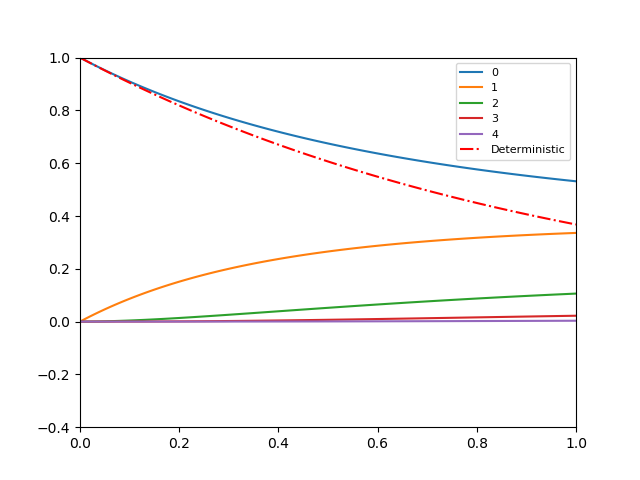

In [402]:
plt.figure()
plt.ylim([-0.4,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
#     plt.plot(x,(-1)**i*sol_ch[:,i],label=i)
    plt.plot(x,sol_ch[:,i],label=i)

plt.plot(x, y_determ_ch(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [396]:
allcoeff_534 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_534[0,:]=np.ones(4)
allcoeff_534[1,:]=-1*np.ones(4)
y_534 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
#h = unif_icdf([-1,1])                          #index k follows uniform distr
a=0
for i in range(4):
    P=i+1
    ki_ch = allcoeff_534[:,i]
    y_mid=odeint(ode_system_ch, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_534[:,i] = y_mid.tolist()+[0]*(4-P)

In [397]:
y_534

array([[0.51403683, 0.53036564, 0.53141456, 0.53146206],
       [0.27260987, 0.3302384 , 0.3356191 , 0.33593496],
       [0.        , 0.09210466, 0.10510441, 0.10612773],
       [0.        , 0.        , 0.02012489, 0.02222193],
       [0.        , 0.        , 0.        , 0.00326755]])

In [398]:
mean_534 = y_534[0,:]

mean_exact_534 = np.e**(-1+np.e**(-1))

error_mean_534=(mean_534 - mean_exact_534)/mean_exact_534

error_mean_534 = np.abs(error_mean_534)

In [399]:
sigma2_534=np.zeros(4)

for i in range(4):
    sigma2_534[i]=y_534[1,i]**2+2*y_534[2,i]**2+6*y_534[3,i]**2+24*y_534[4,i]**2
    
sigma2_exact_534 = np.e**(-1+np.e**(-2))-np.e**(-2+2*np.e**(-1))

error_var_534=(sigma2_534-sigma2_exact_534)/sigma2_exact_534

error_var_534 = np.abs(error_var_534)

<IPython.core.display.Javascript object>


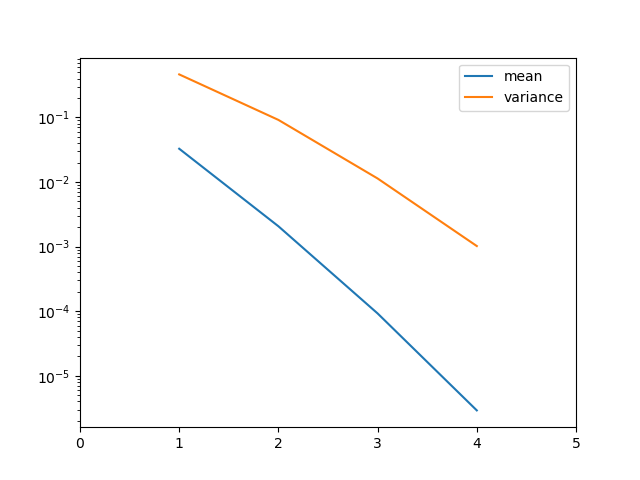

In [400]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_534,label='mean')
plt.semilogy([1,2,3,4],error_var_534,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

## 5.3.5 Binomial distribution and Krawtchouk-chaos

$$ f(k; p, N) = \binom{N}{k} p^k (1-p)^{N-k}$$

Here assume $p=0.5, N=5$, then $k\sim poisson(1)$

Inverse CDF of $k$ is $h(u)$, here it is `binom_icdf((5, 0.5))`
$$ \zeta \sim B(5, 0.5)$$

In [469]:
def Krawt(params):
    '''
    The first 4 (degree from 0 to 4) Krawtchouk polynomial
    Follow definition on P641
    '''
    n = params[0]  #degree
    p = params[1]  #parameter value
    N = params[2]  #parameter value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1-u/(N*p)
    elif n==2:
        return lambda u: 1-2*u/(N*p)+(u**2-u)/(p**2*(N**2-N))
    elif n==3:
        return lambda u: 1-3*u/(N*p)+3*(u**2-u)/(p**2*(N**2-N))+(-1)*(-u**3+3*u**2-2*u)/(p**3*(-N**3+3*N**2-2*N))
    else: #this actually means n=4
        return lambda u: 1-4*u/(N*p)+6*(u**2-u)/(p**2*(N**2-N))+(-4)*(-u**3+3*u**2-2*u)/(p**3*(-N**3+3*N**2-2*N))+(u**4-6*u**3+11*u**2-6*u)/(p**4*(N**4-6*N**3+11*N**2-6*N))

In [424]:
############# Charlier Chaos ###############
def product3_kr(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: Krawt((i,0.5,5))(x)*Krawt((j,0.5,5))(x)*Krawt((l,0.5,5))(x)

def inner3_kr(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    N = 5
    p = 0.5
    for k in range(N+1):
        inner += factorial(5)*(0.5**5)*product3_kr(i,j,l)(k)/(factorial(k)*factorial(5-k))
    
    return inner

In [425]:
def ode_system_kr(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_kr(P,i,j,l)*ki_kr[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_kr((l,0.5,5))
    return dydt

In [426]:
a = 0
h = binom_icdf((5,0.5))                          #index k follows binom distr
P = 4
ki_kr = [2.5,-2.5]+[0]*(P-1)
sol_kr = odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

In [427]:
def y_determ_ch(x):
    return np.e**(-2.5*x)

<IPython.core.display.Javascript object>


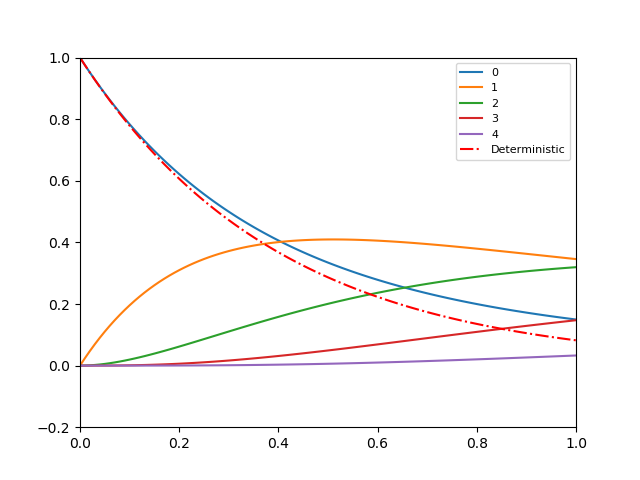

In [428]:
plt.figure()
plt.ylim([-0.2,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_kr[:,i],label=i)

plt.plot(x, y_determ_kr(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [446]:
def f(params):
    n = params
    return lambda u:u**n

for i in range(9):
    print(binom.expect(f(i), args=(5, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
2.5
7.499999999999999
24.999999999999996
89.99999999999999
343.74999999999994
1376.2499999999998
5724.999999999999
24577.499999999996


In [459]:
def g(params):
    n = params
    return lambda u: (Krawt((n,0.5,5))(u))**2

for i in range(1,5):
    print(binom.expect(g(i), args=(5, 0.5), loc=0, lb=None, ub=None, conditional=False))

0.19999999999999996
0.09999999999999998
0.09999999999999999
0.20000000000000007


In [461]:
allcoeff_535 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_535[0,:]=2.5*np.ones(4)
allcoeff_535[1,:]=-2.5*np.ones(4)
y_535 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
#h = unif_icdf([-1,1])                          #index k follows uniform distr
a=0
for i in range(4):
    P=i+1
    ki_kr = allcoeff_535[:,i]
    y_mid=odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_535[:,i] = y_mid.tolist()+[0]*(4-P)

In [462]:
mean_535 = y_535[0,:]

mean_exact_535 = (1-0.5+0.5*np.e**(-1))**5

error_mean_535=(mean_535 - mean_exact_535)/mean_exact_535

error_mean_535 = np.abs(error_mean_535)

In [463]:
sigma2_535=np.zeros(4)

for i in range(4):
    sigma2_535[i]=0.2*y_535[1,i]**2+0.1*y_535[2,i]**2+0.1*y_535[3,i]**2+0.2*y_535[4,i]**2
    
sigma2_exact_535 = (1-0.5+0.5*np.e**(-2))**5 - (1-0.5+0.5*np.e**(-1))**10

error_var_535=(sigma2_535-sigma2_exact_535)/sigma2_exact_535

error_var_535 = np.abs(error_var_535)

In [466]:
error_mean_535

array([7.14604930e-02, 5.18339776e-03, 1.79097385e-04, 2.39712927e-06])

<IPython.core.display.Javascript object>


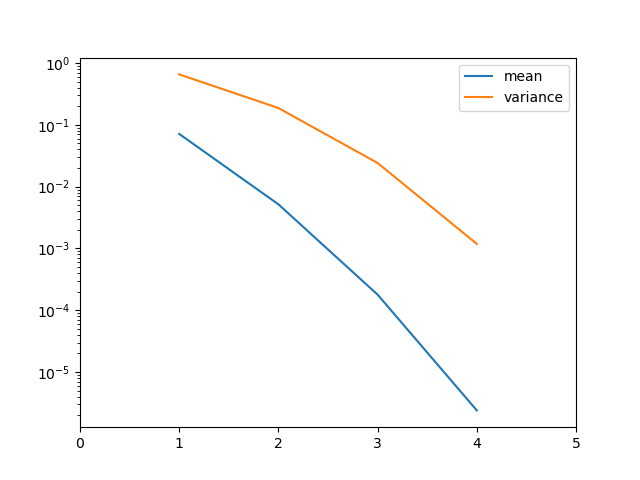

In [464]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_535,label='mean')
plt.semilogy([1,2,3,4],error_var_535,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

## 5.3.6 Negative binomial distribution and Meixner-chaos

$$ f(k; \beta, c) = \frac{(\beta)_k}{k!} (1-c)^{\beta} c^k$$

Here assume $\beta=1, c=0.5$, then $k\sim NB(\beta, c)$

Inverse CDF of $k$ is $h(u)$, here it is `nbinom_icdf((1,0.5))`
$$ \zeta \sim NB(1, 0.5)$$

In [479]:
def Meix(params):
    '''
    The first 4 (degree from 0 to 4) Meixner polynomial
    Follow definition on P642
    '''
    n = params[0]  #degree
    b = params[1]  #parameter beta value
    c = params[2]  #parameter c value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1+u*(1-1/c)/b
    elif n==2:
        return lambda u: 1+2*u*(1-1/c)/b+(u**2-u)*(1-1/c)**2/(b**2+b)
    elif n==3:
        return lambda u: 1+3*u*(1-1/c)/b+3*(u**2-u)*(1-1/c)**2/(b**2+b)+(-1)*(-u**3+3*u**2-2*u)*(1-1/c)**3/(b**3+3*b**2+2*b)
    else: #this actually means n=4
        return lambda u: 1+4*u*(1-1/c)/b+6*(u**2-u)*(1-1/c)**2/(b**2+b)+(-4)*(-u**3+3*u**2-2*u)*(1-1/c)**3/(b**3+3*b**2+2*b)+(u**4-6*u**3+11*u**2-6*u)*(1-1/c)**4/(b**4+6*b**3+11*b**2+6*b)

In [480]:
############# Meixner Chaos ###############
def product3_me(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: Meix((i,1,0.5))(x)*Meix((j,1,0.5))(x)*Meix((l,1,0.5))(x)

def inner3_me(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    b = 1    #beta value
    c = 0.5
    for k in range(11):
        inner += factorial_rev((b, k))*((1-c)**b)*(c**k)*product3_me(i,j,l)(k)/factorial(k)
    
    return inner

In [481]:
def ode_system_me(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_me(P,i,j,l)*ki_me[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_me((l,1,0.5))
    return dydt

In [482]:
a = 0
h = nbinom_icdf((1, 0.5))       #index k follows negative binom distr
P = 4
ki_me = [1,-1]+[0]*(P-1)
sol_me = odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

In [483]:
def y_determ_me(x):
    return np.e**(-x)

<IPython.core.display.Javascript object>


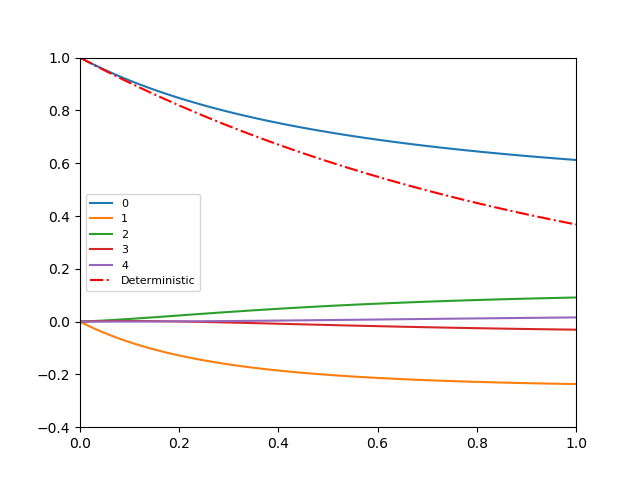

In [485]:
plt.figure()
plt.ylim([-0.4,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,(-1)**i*sol_me[:,i],label=i)

plt.plot(x, y_determ_me(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [ ]:
nbinom.expect(func, args=(n, p), loc=0, lb=None, ub=None, conditional=False)

In [486]:
def f(params):
    n = params
    return lambda u:u**n

for i in range(9):
    print(nbinom.expect(f(i), args=(1, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
1.0
3.0000000000000004
13.000000000000002
75.00000000000001
541.0000000000001
4683.000000000001
47293.00000000001
545835.0000000001


In [488]:
def g(params):
    n = params
    return lambda u: (Meix((n,1,0.5))(u))**2

for i in range(1,5):
    print(nbinom.expect(g(i), args=(1, 0.5), loc=0, lb=None, ub=None, conditional=False))

2.0000000000000004
4.000000000000001
8.000000000000002
16.000000000000007


In [489]:
allcoeff_536 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_536[0,:]=1*np.ones(4)
allcoeff_536[1,:]=-1*np.ones(4)
y_536 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
#h = unif_icdf([-1,1])                          #index k follows uniform distr
a=0
for i in range(4):
    P=i+1
    ki_me = allcoeff_536[:,i]
    y_mid=odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_536[:,i] = y_mid.tolist()+[0]*(4-P)

In [497]:
b=2
c=0.2

mean_536 = y_536[0,:]

mean_exact_536 = ((1-c)/(1-c*np.e**(-1)))**b

error_mean_536=(mean_536 - mean_exact_536)/mean_exact_536

error_mean_536 = np.abs(error_mean_536)

In [498]:
sigma2_536=np.zeros(4)

for i in range(4):
    sigma2_536[i]=2*y_536[1,i]**2+4*y_536[2,i]**2+8*y_536[3,i]**2+16*y_536[4,i]**2
    
sigma2_exact_536 = ((1-c)/(1-c*np.e**(-1)))**b - ((1-c)/(1-c*np.e**(-1)))**(2*b)

error_var_536=(sigma2_536-sigma2_exact_536)/sigma2_exact_536

error_var_536 = np.abs(error_var_536)

<IPython.core.display.Javascript object>


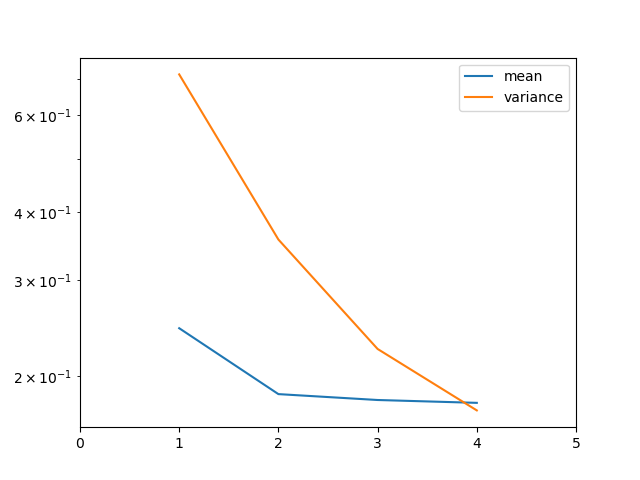

In [499]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_536,label='mean')
plt.semilogy([1,2,3,4],error_var_536,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

## 5.3.7 Hypergeometric distribution and Hahn-chaos

$$ f(k; \alpha, \beta, N) = \frac{\binom{\alpha}{k} \binom{\beta}{N-k}}{\binom{\alpha+\beta}{N}} $$

Here assume $\alpha=\beta=5, N=4$

Inverse CDF of $k$ is $h(u)$, here it is `nbinom_icdf((1,0.5))`
$$ \zeta \sim NB(1, 0.5)$$

In [527]:
def Hahn(params):
    '''
    The first 4 (degree from 0 to 4) Krawtchouk polynomial
    Follow definition on P641
    '''
    n = params[0]  #degree
    a = params[1]
    b = params[2]  #parameter value
    N = params[3]  #parameter value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1+(-1)*(a+b)*(-u)/((a+1)*(-N))
    elif n==2:
        return lambda u: 1+(-2)*(a+b-1)*(-u)/((a+1)*(-N))+(-2)*(-1)*(a+b-1)*(a+b)*(u**2-u)/((a+1)*(a+2)*(N**2-N)*2)
    elif n==3:
        return lambda u: 1+(-3)*(a+b-2)*(-u)/((a+1)*(-N))+(-3)*(-2)*(a+b-2)*(a+b-1)*(u**2-u)/((a+1)*(a+2)*(N**2-N)*2)+(-3)*(-2)*(-1)*(a+b-2)*(a+b-1)*(a+b)*(-u**3+3*u**2-2*u)/((a+1)*(a+2)*(a+3)*(-N**3+3*N**2-2*N)*6)
    else: #this actually means n=4
        return lambda u: 1+(-4)*(a+b-3)*(-u)/((a+1)*(-N))+(-4)*(-3)*(a+b-3)*(a+b-2)*(u**2-u)/((a+1)*(a+2)*(N**2-N)*2)+(-4)*(-3)*(-2)*(a+b-3)*(a+b-2)*(a+b-1)*(-u**3+3*u**2-2*u)/((a+1)*(a+2)*(a+3)*(-N**3+3*N**2-2*N)*6)+(-4)*(-3)*(-2)*(-1)*(a+b-3)*(a+b-2)*(a+b-1)*(a+b)*(u**4-6*u**3+11*u**2-6*u)/((a+1)*(a+2)*(a+3)*(a+4)*(N**4-6*N**3+11*N**2-6*N)*24)

In [550]:
############# Hahn Chaos ###############
def product2_hahn(i,j):
    #compute \Phi_i*\Phi_j
    return lambda x: Hahn((i,5,5,4))(x)*Hahn((j,5,5,4))(x)

def inner2_hahn(i,j):
    #compute <\Phi_i\Phi_j>
    inner = 0 
    al = 5 #alpha
    b = 5
    N = 4
    for k in range(N+1):
        inner += factorial(al)*factorial(b)*factorial(N)*factorial(al+b-N)*product2_hahn(i,j)(k)/(factorial(k)*factorial(al-k)*factorial(N-k)*factorial(b-N+k)*factorial(al+b))
    
    return inner

In [540]:
product2_hahn(1,0)(6)

-1.5

In [552]:
inner2_hahn(0,1)

0.16666666666666663

In [518]:
# def inner2_hahn(params):
#     '''
#     n is the degree of Meixner polynomial
#     beta is the parameter of negative binomial
#     c is the parameter of negative binomial
#     '''
#     n = params[0]
#     a = params[1]
#     b = params[2]  #beta
#     N = params[3]
    
#     numerator = (-1)**n*factorial_rev((n+a+b+1, N+1))*factorial_rev((b+1, n))*factorial(n)/((2*n+a+b+1)*factorial_rev((a+1,n))*factorial_rev((-N, n))*factorial(N))
#     denom = factorial(N+a+b+1)/(factorial(N)*factorial(a+b+1))
    
#     return numerator/denom

In [524]:
1-5/3+(5/12)**2*(14/3)

0.1435185185185186

In [526]:
(5+(7/12)**2*50+100/36+50/16+20/9)/210

0.14351851851851855

In [523]:
inner2_hahn((1,5,5,4))

0.3076923076923077

In [510]:
############# Hahn Chaos ###############
def product3_hahn(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: Hahn((i,5,5,4))(x)*Hahn((j,5,5,4))(x)*Hahn((l,5,5,4))(x)

def inner3_hahn(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    al = 5
    b = 5
    N = 4
    for k in range(N+1):
        inner += factorial(al)*factorial(k)*factorial(al-k)*factorial(b)*factorial(N-k)*factorial(b-N+k)*product3_hahn(i,j,l)(k)/(factorial(al+b)/(factorial(N)*factorial(al+b-N)))
    
    return inner

In [511]:
def ode_system_hahn(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_hahn(P,i,j,l)*ki_hahn[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_hahn(l,l)
    return dydt

In [514]:
a = 0
h = hypergeom_icdf((5,5,4))                      #index k follows binom distr
P = 4
ki_hahn = [2.4,-2.4]+[0]*(P-1)
sol_hahn = odeint(ode_system_hahn, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, a)) 

In [515]:
def y_determ_hahn(x):
    return np.e**(-2*x)

<IPython.core.display.Javascript object>


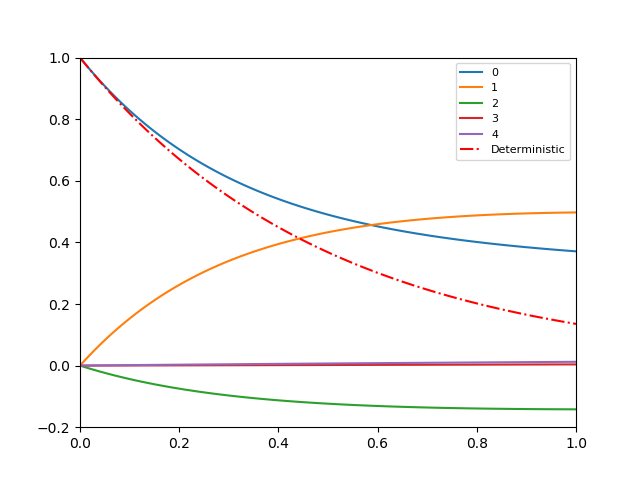

In [517]:
plt.figure()
plt.ylim([-0.2,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,sol_hahn[:,i],label=i)

plt.plot(x, y_determ_hahn(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

In [ ]:
allcoeff_537 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_535[0,:]=2.5*np.ones(4)
allcoeff_535[1,:]=-2.5*np.ones(4)
y_535 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...
#h = unif_icdf([-1,1])                          #index k follows uniform distr
a=0
for i in range(4):
    P=i+1
    ki_kr = allcoeff_535[:,i]
    y_mid=odeint(ode_system_kr, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:]
    y_535[:,i] = y_mid.tolist()+[0]*(4-P)

In [ ]:
mean_535 = y_535[0,:]

mean_exact_535 = (1-0.5+0.5*np.e**(-1))**5

error_mean_535=(mean_535 - mean_exact_535)/mean_exact_535

error_mean_535 = np.abs(error_mean_535)

In [ ]:
sigma2_535=np.zeros(4)

for i in range(4):
    sigma2_535[i]=0.2*y_535[1,i]**2+0.1*y_535[2,i]**2+0.1*y_535[3,i]**2+0.2*y_535[4,i]**2
    
sigma2_exact_535 = (1-0.5+0.5*np.e**(-2))**5 - (1-0.5+0.5*np.e**(-1))**10

error_var_535=(sigma2_535-sigma2_exact_535)/sigma2_exact_535

error_var_535 = np.abs(error_var_535)

In [ ]:
plt.figure()
plt.xlim([0,5])
plt.semilogy([1,2,3,4],error_mean_535,label='mean')
plt.semilogy([1,2,3,4],error_var_535,label='variance')     #regard $\sigma(t)$, $\sigma_{exact}(t)$ both as the variance
plt.legend()

### Second-order Runge-Kutta method to solve $x' = f(x,t)$ with $x(t[0]) = x_0$

## <font color = blue >Compute the coefficient $k_i$ with respect to Hermite Chaos

In [371]:
############## Hermite Chaos ################
def coeff_herm(P,h):
    '''
    P is the highest degree of Hermite-Chaos we are gonna use
    h is the inverse pdf of k
    '''
    ki=[0]*(P+1)
        
    for i in range(0, P+1):
        #numerator
        function = lambda u:h(u)*H.hermeval(norm.ppf(u, loc=0, scale=1), Phi(i))     #Gauss quadrature
        num = G_qua(function,0,1)[0]
        #integrand=lambda u:h(u)*H.hermeval(norm.ppf(u, loc=0, scale=1), Phi(i))     ###norm.ppf
        #ki[i]=G_qua(h_phi_l(h,i), 0, 1)/inner2_herm(i)
        #ki[i]=trapezoid_int(integrand, 0.001, 1-0.001, 5000)/inner2_herm(i)
        ki[i] = num/inner2_herm(i)
    return ki  

## 6.3.1 Approximation of gamma distribution by Hermite Chaos
$$ f(k) = \frac{e^{-k} k^{\alpha}}{\Gamma(\alpha+1)}$$

Here assume $\alpha=0$, then $f(k) = e^{-k}$

Inverse CDF of $k$ is $h(u)$, here it is `expo_icdf([])`
$$ \zeta \sim N(0,1)$$
Inverse CDF of $\zeta$ is $l(u)$ which is indicated in `coeff_herm(P, h)`

In [373]:
h = expo_icdf([])                          
k_631 = coeff_herm(6,h)

/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.010561e-05
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.953355e-05
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.861170e-04
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.171238e-03
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.072197e-03
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceed

<IPython.core.display.Javascript object>


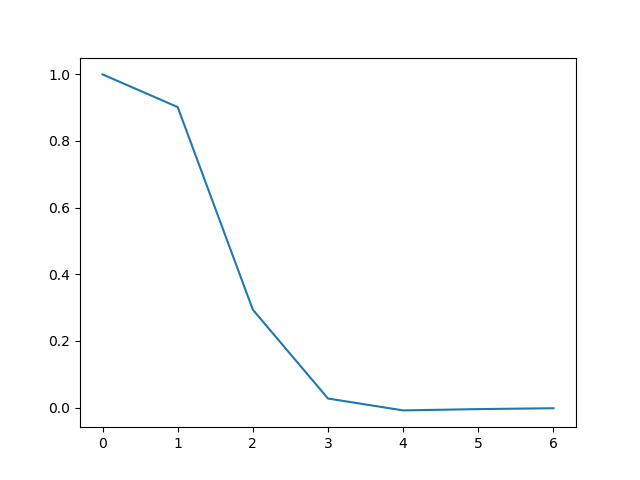

In [374]:
plt.figure()
plt.plot([0,1,2,3,4,5,6],k_631)

In [167]:
def rk2a( f, x0, t ):
    """Second-order Runge-Kutta method to solve x' = f(x,t) with x(t[0]) = x0.

    USAGE:
        x = rk2a(f, x0, t)

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a NumPy array.  In this
                case f must return a NumPy array with the same dimension
                as x.
        x0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or NumPy array
                if a system of equations is being solved.
        t     - list or NumPy array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.

    OUTPUT:
        x     - NumPy array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.

    NOTES:
        This version is based on the algorithm presented in "Numerical
        Analysis", 6th Edition, by Burden and Faires, Brooks-Cole, 1997.
    """

    n = len( t )
    x = numpy.array( [ x0 ] * n )
    for i in xrange( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( x[i], t[i] ) / 2.0
        x[i+1] = x[i] + h * f( x[i] + k1, t[i] + h / 2.0 )

    return x

In [ ]:
rk2a( f, x0, t )

In [376]:
def ode_system_herm(y, t, P, a):   #a is extra, I don't know how to get rid of it
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_herm(P,i,j,l)*ki_herm[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_herm(l)
    return dydt

In [377]:
#N=5000
#S=np.random.normal(loc=0, scale=1, size=N)
y_631 = np.zeros((6,3))

h = expo_icdf([])                          #index k follows expo distr
a=0

for i in range(3):
    P=i*2+1
    ki_herm = coeff_herm(P, h)
    y_mid=odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, a))[1,:] #return coeff in expansion of y(t)
    y_631[:,i] = y_mid.tolist()+[0]*(5-P)
    

/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.010561e-05
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.953355e-05
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.861170e-04
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.171238e-03
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.072197e-03
  AccuracyWarning)
/Users/zwj/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceed

In [381]:
#generate sample when P=1,3,5
N=1000
xi=np.zeros(N)
xi= np.random.normal(loc=0, scale=1, size=N)

In [382]:
ysample_631 = np.zeros((3,1000))
for i in range(3):
    ysample_631[i,:] = y_631[0,i]+y_631[1,i]*xi+y_631[2,i]*(xi**2-1)+y_631[3,i]*(xi**3-3*xi)+y_631[4,i]*(xi**4-6*xi**2+3)+y_631[5,i]*(xi**5-10*xi**3+15*xi)   

<IPython.core.display.Javascript object>


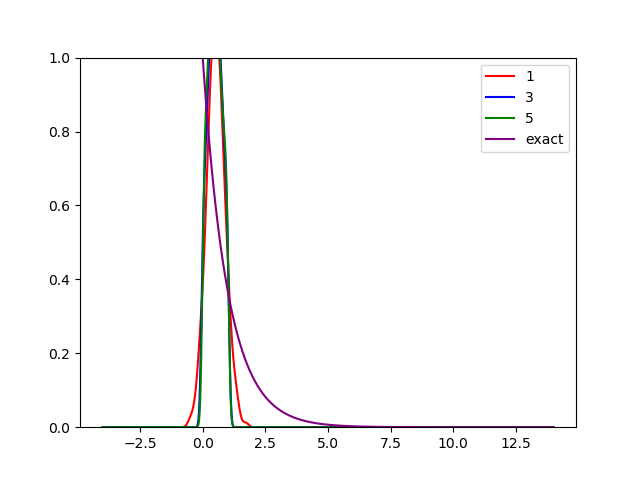

In [383]:
fig, ax1 = plt.subplots(1, 1)
x = np.linspace(-4,14,10000)
y_approx1_631=kde(ysample_631[0,:])
y_approx3_631=kde(ysample_631[1,:])
y_approx5_631=kde(ysample_631[2,:])
def y_exact_631(x):
    return np.e**(-x)

ax1.plot(x, y_approx1_631(x), c='red', label=1)
ax1.plot(x, y_approx3_631(x), c='blue', label=3)
ax1.plot(x, y_approx5_631(x), c='green', label=5)
ax1.plot(x, y_exact_631(x), c='purple', label='exact')

plt.ylim(0, 1)

plt.legend()

In [403]:
np.sign(-2)

-1

In [404]:
norm.ppf(0.1)

-1.2815515655446004

In [406]:
u = 0.1
t = np.sqrt(-np.log(np.min([u,1-u])**2))

In [407]:
c0= 2.515517
c1 = 0.802853
c2 = 0.010328
d1 = 1.432788
d2 = 0.189269
d3 = 0.001308
l_u = np.sign(u-0.5)*(t-(c0+c1*t+c2*t**2)/(1+d1*t+d2*t**2+d3*t**3))
print(l_u)

-1.281728756502709


<IPython.core.display.Javascript object>


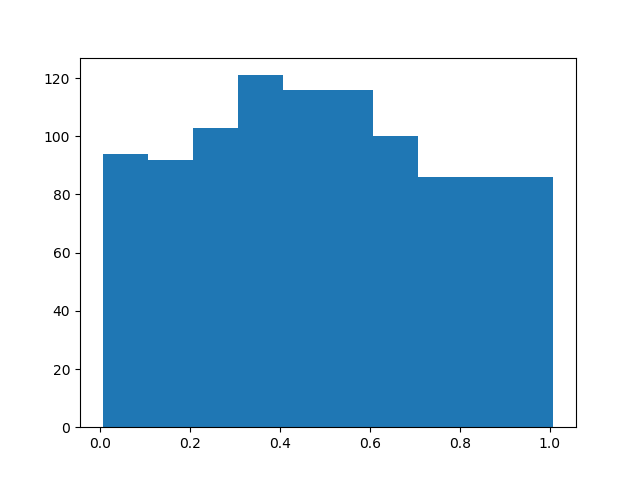

(array([ 94.,  92., 103., 121., 116., 116., 100.,  86.,  86.,  86.]),
 array([0.0046493 , 0.10502295, 0.2053966 , 0.30577025, 0.4061439 ,
        0.50651755, 0.6068912 , 0.70726485, 0.8076385 , 0.90801215,
        1.0083858 ]),
 <a list of 10 Patch objects>)

In [408]:
plt.figure()
plt.hist(ysample_631[2,:])